### Add path to structure learning library (skip if installed via pip)

In [1]:
import sys
sys.path.append('../src')

### Import relevant classes, set random seed

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from structure_learning.data import SyntheticDataset, Data
from structure_learning.distributions import Distribution
from structure_learning.experiments import Experiment
from structure_learning.evaluation.metrics import RHat
# for reproducibility
np.random.seed(100)

### 1. Setup experiment by defining an instance of Experiment class

In [3]:
# setup synthetic data
num_nodes = 5
node_labels = [chr(ord('a') + i) for i in range(num_nodes)]
num_obs = 200
degree = 2

synthetic_data = SyntheticDataset(num_nodes=num_nodes, num_obs=num_obs, node_labels=node_labels, degree=degree)

00010 00100 10000 00000 01010


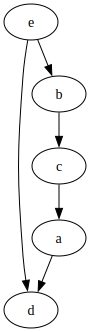

In [4]:
# visualise ground truth DAG
synthetic_data.graph.plot()

#### configurations of samplers to run

In [ ]:
samplers = [
    {
        "sampler_type": "StructureMCMC",
        "n_chains": 2,
        "config": {
            "max_iter": 100000,
            "score_object": "bge",
            "pc_init": False,
            "result_type": "distribution",
            "graph_type": "cpdag",
        }
    },
    {
        "sampler_type": "PartitionMCMC",
        "n_chains": 2,
        "config": {
            "max_iter": 100000,
            "score_object": "bge",
            "result_type": "distribution",
            "graph_type": "cpdag",
            "searchspace": "FULL"
        }
    }
]

#### run the experiment

In [6]:
exp = Experiment(experiment_name='test', data=synthetic_data.data, samplers=samplers, n_threads=8, seed=42)
res = exp.run()

#### compute the Rhat from the distribution results

In [8]:
rhat = RHat()
rhat.compute([r[0] for r in res if isinstance(r[0], Distribution)])

1.0006375284415374

#### plot distributions

/Users/165421/Documents/code/structure_learning/examples/../src/structure_learning/distributions/distribution.py:209: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(a_melt['index'], rotation=90)


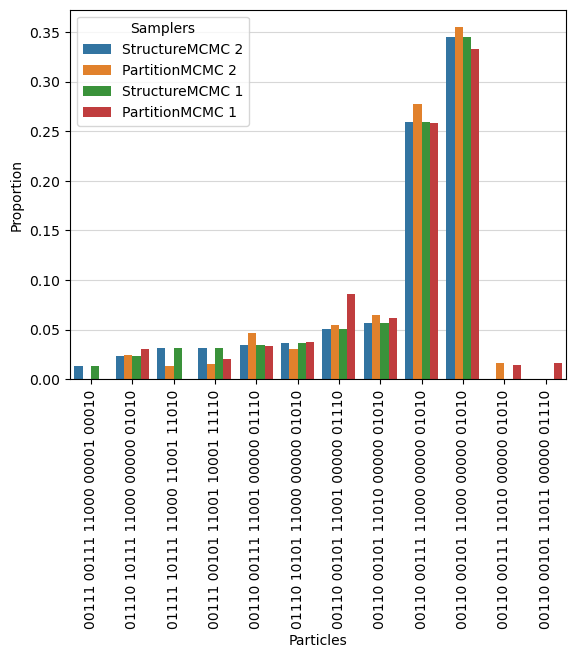

In [7]:

sampler_types = [f'{sampler['sampler_type']} {i+1}' for sampler in samplers for i in range(sampler['n_chains'])]
_ = Distribution.plot_multiple([r[0] for r in res if isinstance(r[0], Distribution)], prop='p', labels=sampler_types, limit=10)